In [382]:
# Imports
import wfdb
import matplotlib.pyplot as plt
from constants import *
from main import *
import h5py
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [383]:
# Get all records

record_list = get_all_records(TRAIN_PATH, "RECORDS")
len(record_list)

994

In [384]:
def transform_undef(hypnogram):
    hypnogram[hypnogram == 0] = 5
    return hypnogram

def create_random_hypno(shape):
    return transform_undef(np.random.randint(6, size=(shape)))

def plot_hypnogram(hypnogram, name):
    plt.figure(figsize=(12, 3))
    plt.yticks(list(TICK_LABELS.keys()),
               list(TICK_LABELS.values()),
               size=12)
    plt.xlabel("epochs", size=12)
    plt.xticks(size=12)
    plt.title(name)
    plt.grid()
    plt.plot(hypnogram)
    plt.show()

def contingency_table(conf_mat):
    total = np.sum(conf_mat)
    total_rand = np.sum(conf_mat, axis=0)
    
    total_real = np.sum(conf_mat, axis=1)
    total_real = np.append(total_real, total)
    
    conf_mat = np.vstack((conf_mat, total_rand))
    
    return np.concatenate((conf_mat, total_real[:, None]), axis=1)


def get_mask():
    my_mask = np.array([[False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [True,True,True,True,True,True]])
    return my_mask


def plot_contigency_table(hypnogram, random_hypnogram, name):
    
    labels = ["N3","N2","N1","REM","WAKE","TOTAL"]
    fig, ax = plt.subplots(figsize=(6, 4))
    
    conf_mat = confusion_matrix(hypnogram, random_hypnogram)
    cont_table = contingency_table(conf_mat)
    
    sns.heatmap(cont_table, cmap='YlOrRd', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels,
                mask=get_mask())
    sns.heatmap(cont_table, cmap='binary', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels, ax = ax,
                cbar=False, mask=~get_mask())
    
    ax.set_ylabel("real value")
    ax.set_xlabel("random value")
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    plt.title(name)
    plt.show()

In [385]:
# Try for one (first) record
sleep_stages, name,_ = get_converted_sleep_stages(TRAIN_PATH+
                                                  "tr03-0005/tr03-0005-arousal.mat")
ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
rand_hypnogram = create_random_hypno(ref_hypnogram.shape)

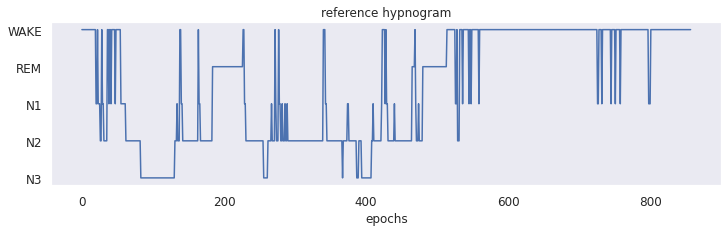

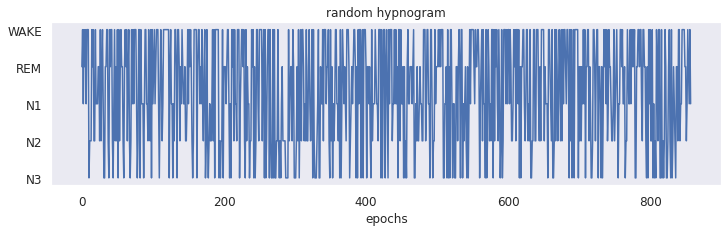

In [386]:
plot_hypnogram(ref_hypnogram, "reference hypnogram")
plot_hypnogram(rand_hypnogram, "random hypnogram")

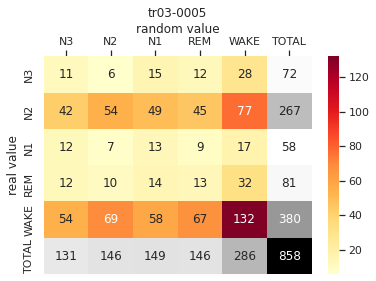

In [387]:
plot_contigency_table(ref_hypnogram, rand_hypnogram, name)

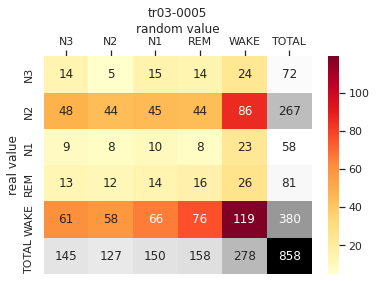

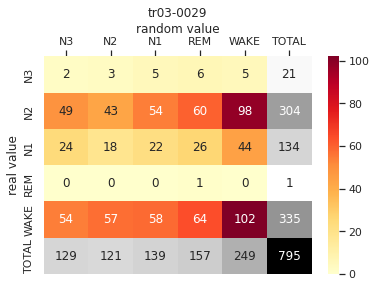

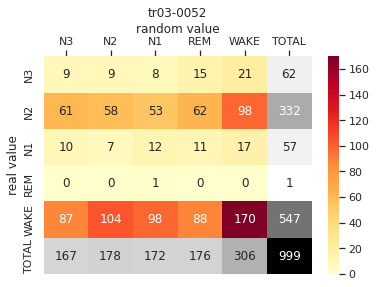

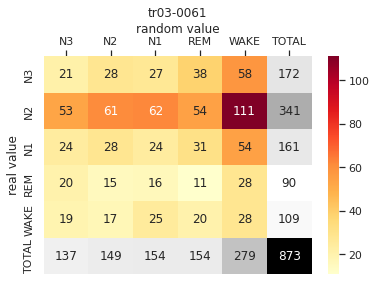

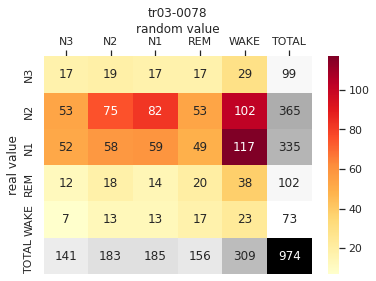

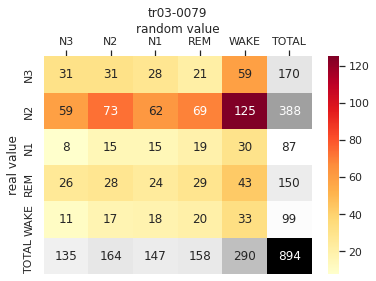

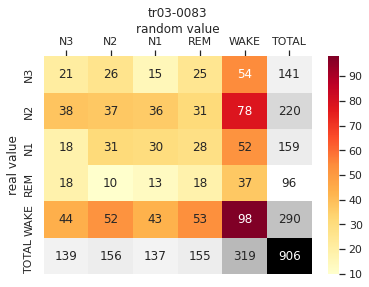

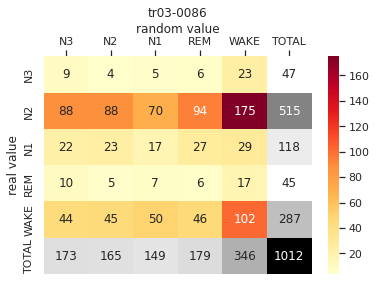

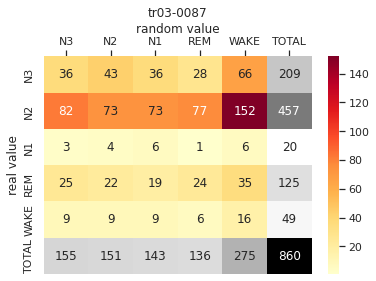

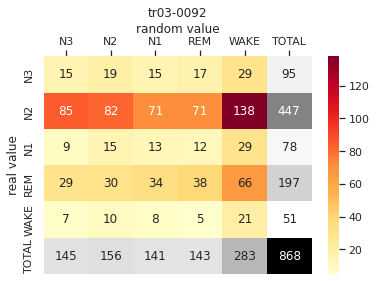

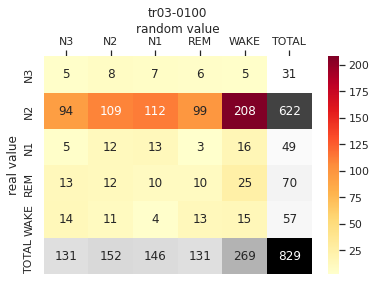

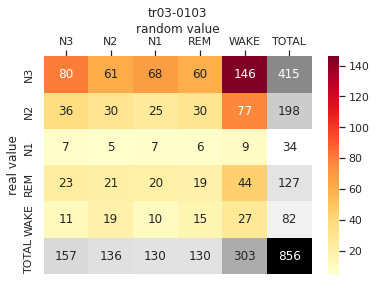

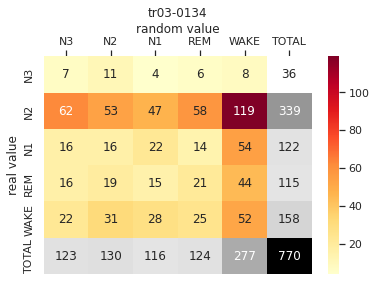

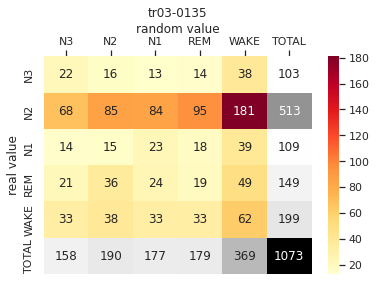

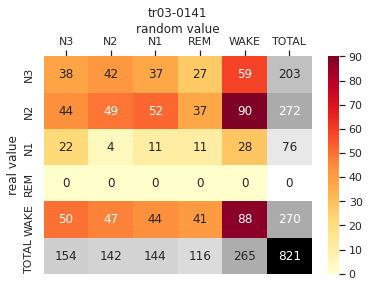

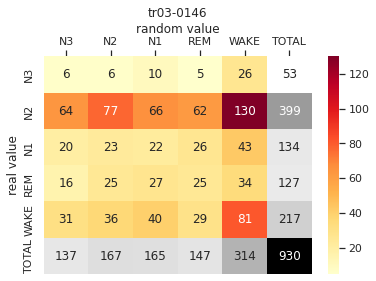

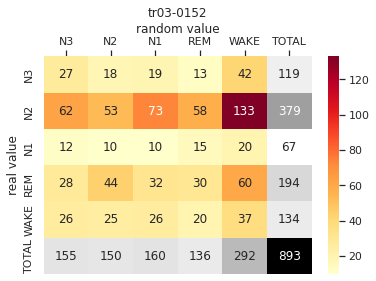

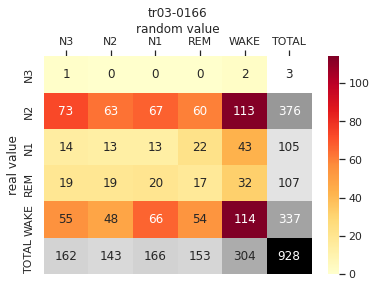

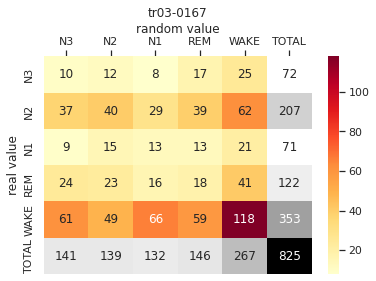

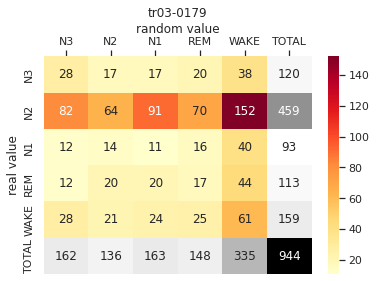

In [388]:
# Iterate over the dataset
i = 0
for record in record_list:
    
    sleep_stages, name, _ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
    rand_hypnogram = create_random_hypno(ref_hypnogram.shape)
    
    plot_contigency_table(ref_hypnogram, rand_hypnogram, name)

    i+=1
    if i == 20:
        break